# Вариант 12

#### Применяемые методы: 
    Метод опорных векторов 	
    Градиентный бустинг

## Задание

Для заданного набора данных постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных).

Для построения моделей используйте методы: Метод опорных векторов, Градиентный бустинг. 

Оцените качество моделей на основе подходящих метрик качества (двух).

    Какие метрики качества Вы использовали и почему? 

    Какие выводы Вы можете сделать о качестве построенных моделей? 

Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

## Реализация

### Импорт библиотек

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from io import StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV



%matplotlib inline 
sns.set(style="ticks")

# скроем предупреждения о возможных ошибках для лучшей читаемости
import warnings
warnings.filterwarnings('ignore')

### Смотрим на датасет

In [102]:
df = pd.read_csv('./dc-wikia-data.csv')

In [103]:
df.shape

(6896, 13)

In [104]:
df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3093.0,"1939, May",1939.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2496.0,"1986, October",1986.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,1565.0,"1959, October",1959.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,NaN,Living Characters,1316.0,"1987, February",1987.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,1237.0,"1940, April",1940.0


In [105]:
df.describe()

,page_id,APPEARANCES,YEAR
count,6896.000000,6541.000000,6827.000000
mean,147441.209252,23.625134,1989.766662
std,108388.631149,87.378509,16.824194
min,1380.000000,1.000000,1935.000000
25%,44105.500000,2.000000,1983.000000
50%,141267.000000,6.000000,1992.000000
75%,213203.000000,15.000000,2003.000000
max,404010.000000,3093.000000,2013.000000


In [106]:
print("Размер набора:")
print(f'В датасете {df.shape[0]} строк и {df.shape[1]} колонок.')

Размер набора:
В датасете 6896 строк и 13 колонок.


In [107]:
df.dtypes

page_id               int64
name                 object
urlslug              object
ID                   object
ALIGN                object
EYE                  object
HAIR                 object
SEX                  object
GSM                  object
ALIVE                object
APPEARANCES         float64
FIRST APPEARANCE     object
YEAR                float64
dtype: object

In [108]:
df.isnull().sum()

page_id                0
name                   0
urlslug                0
ID                  2013
ALIGN                601
EYE                 3628
HAIR                2274
SEX                  125
GSM                 6832
ALIVE                  3
APPEARANCES          355
FIRST APPEARANCE      69
YEAR                  69
dtype: int64

In [109]:
df = df.drop(columns=['ID', 'YEAR', 'GSM', 'urlslug', 'page_id'])
df = df.dropna()

In [110]:
df.shape

(2428, 8)

In [111]:
df.isnull().sum()

name                0
ALIGN               0
EYE                 0
HAIR                0
SEX                 0
ALIVE               0
APPEARANCES         0
FIRST APPEARANCE    0
dtype: int64

## Приступаем к выбору задачи и ее решению

Признак "ALIGN" выберем как целевой. Для этого заменим переменные

In [112]:
cleanup_nums = {"ALIGN":     {"Good Characters": 1, "Bad Characters": 0, "Neutral Characters": pd.NA, "Reformed Criminals": pd.NA}}

df = df.replace(cleanup_nums)

In [113]:
df.isnull().sum()

name                  0
ALIGN               271
EYE                   0
HAIR                  0
SEX                   0
ALIVE                 0
APPEARANCES           0
FIRST APPEARANCE      0
dtype: int64

In [114]:
df = df.dropna()
df.isnull().sum()

name                0
ALIGN               0
EYE                 0
HAIR                0
SEX                 0
ALIVE               0
APPEARANCES         0
FIRST APPEARANCE    0
dtype: int64

In [115]:
df["ALIGN"].value_counts()

1    1245
0     912
Name: ALIGN, dtype: int64

In [116]:
df.dtypes

name                 object
ALIGN                object
EYE                  object
HAIR                 object
SEX                  object
ALIVE                object
APPEARANCES         float64
FIRST APPEARANCE     object
dtype: object

In [117]:
le = LabelEncoder()
arr_le = le.fit_transform(df['name'])
df['name'] = arr_le

In [118]:
le = LabelEncoder()
arr_le = le.fit_transform(df['EYE'])
df['EYE'] = arr_le

In [119]:
le = LabelEncoder()
arr_le = le.fit_transform(df['HAIR'])
df['HAIR'] = arr_le

In [120]:
le = LabelEncoder()
arr_le = le.fit_transform(df['SEX'])
df['SEX'] = arr_le

In [121]:
le = LabelEncoder()
arr_le = le.fit_transform(df['ALIVE'])
df['ALIVE'] = arr_le

In [122]:
le = LabelEncoder()
arr_le = le.fit_transform(df['FIRST APPEARANCE'])
df['FIRST APPEARANCE'] = arr_le

In [123]:
df.head()

,name,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,FIRST APPEARANCE
0,199,1,2,0,2,1,3093.0,7
1,1876,1,2,0,2,1,2496.0,326
2,731,1,3,3,2,1,1565.0,98
3,898,1,3,16,2,1,1316.0,332
4,1640,1,2,0,2,1,1237.0,11


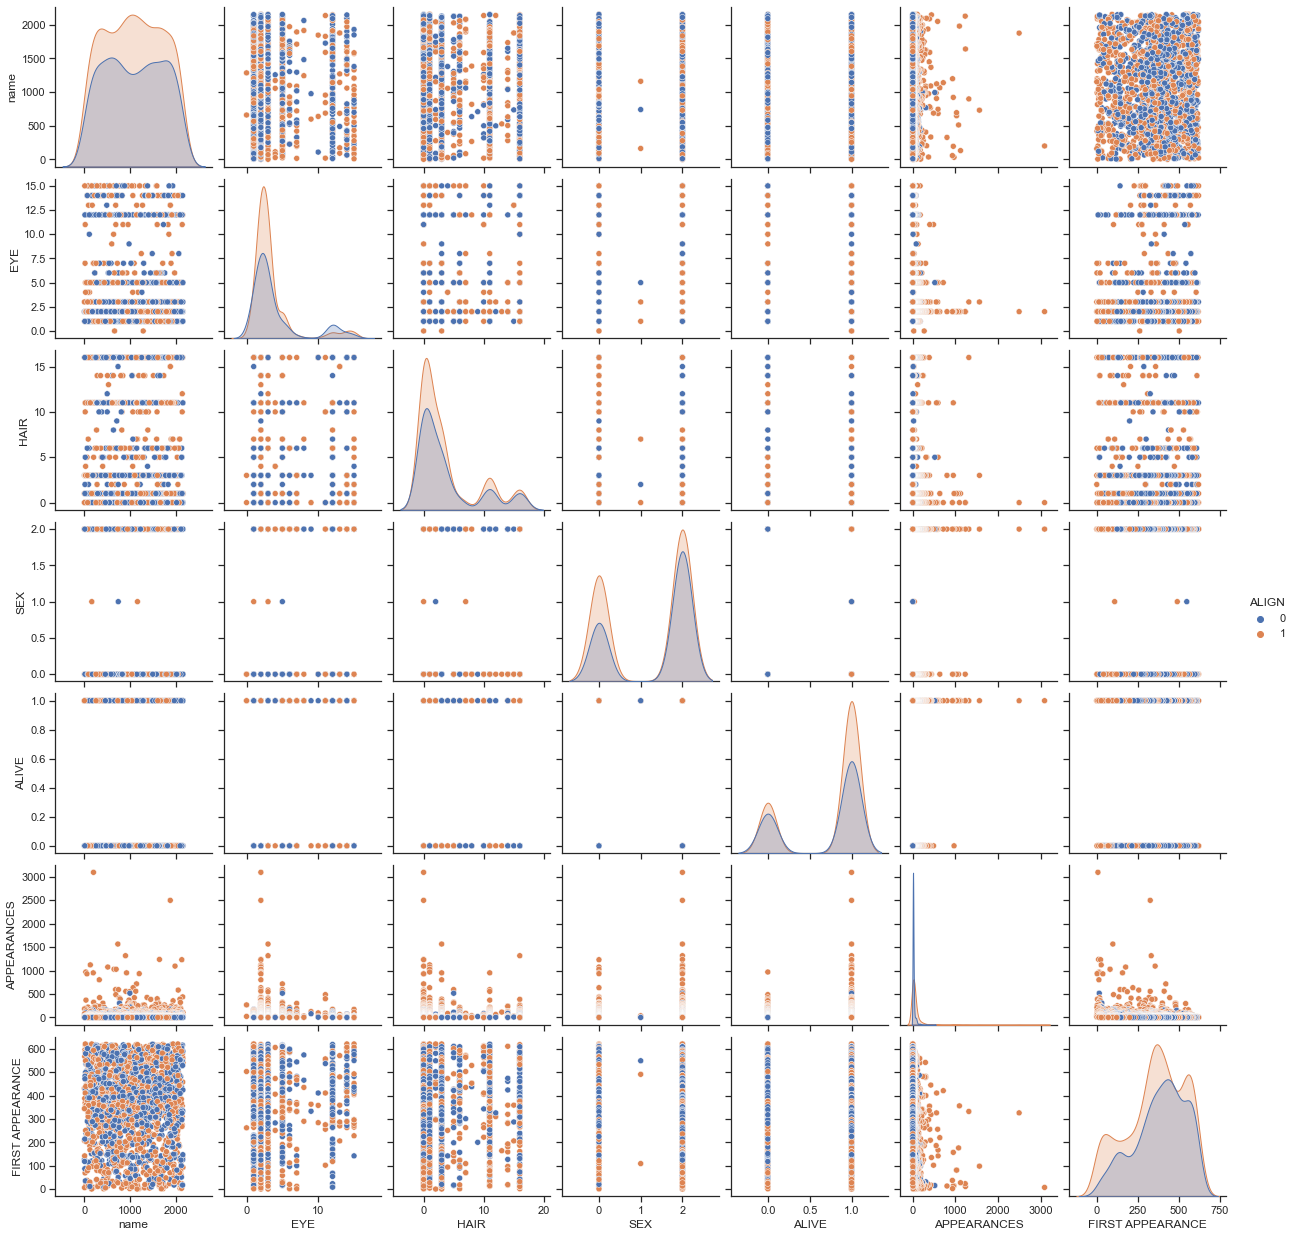

In [124]:
sns.pairplot(df, hue="ALIGN")

In [129]:
df = df.astype('int')

## С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [130]:
X = df.drop('ALIGN', axis=1)
Y = df['ALIGN']

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(1725, 7), (432, 7)
(1725,), (432,)


In [137]:
SVC1 = SVC()
SVC1.fit(X_train, Y_train)

SVC()

In [138]:
My_KNN_target_1_0 = SVC1.predict(X_train)
My_KNN_Y_Pred = SVC1.predict(X_test)
print(f'Accuracy:',     accuracy_score(Y_train,My_KNN_target_1_0), accuracy_score(Y_test,My_KNN_Y_Pred))
print(f'Precision:',    precision_score(Y_train,My_KNN_target_1_0), precision_score(Y_test,My_KNN_Y_Pred))
print(f'F1:',           f1_score(Y_train,My_KNN_target_1_0), f1_score(Y_test,My_KNN_Y_Pred))
print(f'Recall:',       recall_score(Y_train,My_KNN_target_1_0), recall_score(Y_test,My_KNN_Y_Pred))

Accuracy: 0.5727536231884058 0.5949074074074074
Precision: 0.5727536231884058 0.5949074074074074
F1: 0.7283450055289348 0.7460087082728593
Recall: 1.0 1.0


In [139]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train, Y_train)

GradientBoostingClassifier()

In [140]:
My_KNN_target_1_0 = GBC.predict(X_train)
My_KNN_Y_Pred = GBC.predict(X_test)
print(f'Accuracy:',     accuracy_score(Y_train,My_KNN_target_1_0),      accuracy_score(Y_test,My_KNN_Y_Pred))
print(f'Precision:',    precision_score(Y_train,My_KNN_target_1_0),     precision_score(Y_test,My_KNN_Y_Pred))
print(f'F1:',           f1_score(Y_train,My_KNN_target_1_0),            f1_score(Y_test,My_KNN_Y_Pred))
print(f'Recall:',       recall_score(Y_train,My_KNN_target_1_0),        recall_score(Y_test,My_KNN_Y_Pred))

Accuracy: 0.7721739130434783 0.6574074074074074
Precision: 0.7830637488106565 0.693950177935943
F1: 0.807258460029426 0.724907063197026
Recall: 0.832995951417004 0.7587548638132295
